In [ ]:
import sys, os; sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__) if '__file__' in globals() else os.getcwd(), '..')))
#import os; os.chdir(os.path.dirname(os.getcwd()))
from utils.model_loader import get_model_fits
import numpy as np
import pandas as pd
import re
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
data_dir = f"datasets/friedman"
results_dir_local_lambda = "results/regression/single_layer/tanh/friedman"
results_dir_nodewise_lambda = "results/regression/single_layer/tanh/friedman/nodewise_lambda"

model_names_local_lambda = ["Regularized Horseshoe tanh", "Dirichlet Horseshoe tanh", "Dirichlet Student T tanh"]
model_names_nodewise_lambda = ["Regularized Horseshoe tanh nodewise", "Dirichlet Horseshoe tanh nodewise", "Dirichlet Student T tanh nodewise"]


local_lambda_fits = {}
nodewise_lambda_fits = {}

files = sorted(f for f in os.listdir(data_dir) if f.endswith(".npz"))
for fname in files:
    base_config_name = fname.replace(".npz", "")  # e.g., "GAM_N100_p8_sigma1.00_seed1"
    full_config_path = f"{base_config_name}"  # → "type_1/GAM_N100_p8_sigma1.00_seed1"
    local_fit = get_model_fits(
        config=full_config_path,
        results_dir=results_dir_local_lambda,
        models=model_names_local_lambda,
        include_prior=False,
    )
    
    nodewise_fit = get_model_fits(
        config=full_config_path,
        results_dir=results_dir_nodewise_lambda,
        models=model_names_nodewise_lambda,
        include_prior=False,
    )
    

    local_lambda_fits[base_config_name] = local_fit  # use clean key
    nodewise_lambda_fits[base_config_name] = nodewise_fit  # use clean key
    


In [3]:
data_dir = f"datasets/friedman_correlated"
results_dir_local_lambda_correlated = "results/regression/single_layer/tanh/friedman_correlated"
results_dir_nodewise_lambda_correlated = "results/regression/single_layer/tanh/friedman_correlated/nodewise_lambda"

model_names_local_lambda_correlated = ["Regularized Horseshoe tanh", "Dirichlet Horseshoe tanh", "Dirichlet Student T tanh"]
model_names_nodewise_lambda_correlated = ["Regularized Horseshoe tanh nodewise", "Dirichlet Horseshoe tanh nodewise", "Dirichlet Student T tanh nodewise"]


local_lambda_fits_correlated = {}
nodewise_lambda_fits_correlated = {}

files = sorted(f for f in os.listdir(data_dir) if f.endswith(".npz"))
for fname in files:
    base_config_name = fname.replace(".npz", "")  # e.g., "GAM_N100_p8_sigma1.00_seed1"
    full_config_path = f"{base_config_name}"  # → "type_1/GAM_N100_p8_sigma1.00_seed1"
    local_fit_correlated = get_model_fits(
        config=full_config_path,
        results_dir=results_dir_local_lambda_correlated,
        models=model_names_local_lambda_correlated,
        include_prior=False,
    )
    
    nodewise_fit_correlated = get_model_fits(
        config=full_config_path,
        results_dir=results_dir_nodewise_lambda_correlated,
        models=model_names_nodewise_lambda_correlated,
        include_prior=False,
    )
    

    local_lambda_fits_correlated[base_config_name] = local_fit_correlated  # use clean key
    nodewise_lambda_fits_correlated[base_config_name] = nodewise_fit_correlated  # use clean key
    


[WARNING] No files matched: results/regression/single_layer/tanh/friedman_correlated/regularized_horseshoe_tanh/U2/chain_*.csv
[WARNING] No files matched: results/regression/single_layer/tanh/friedman_correlated/dirichlet_horseshoe_tanh/U2/chain_*.csv
[WARNING] No files matched: results/regression/single_layer/tanh/friedman_correlated/dirichlet_student_t_tanh/U2/chain_*.csv
[WARNING] No files matched: results/regression/single_layer/tanh/friedman_correlated/nodewise_lambda/regularized_horseshoe_tanh_nodewise_lambda/U2/chain_*.csv
[WARNING] No files matched: results/regression/single_layer/tanh/friedman_correlated/nodewise_lambda/dirichlet_horseshoe_tanh_nodewise_lambda/U2/chain_*.csv
[WARNING] No files matched: results/regression/single_layer/tanh/friedman_correlated/nodewise_lambda/dirichlet_student_t_tanh_nodewise_lambda/U2/chain_*.csv


In [4]:
import re
import numpy as np
import pandas as pd
from properscoring import crps_ensemble

_FRIEDMAN_KEY = re.compile(r"Friedman_N(\d+)_p\d+_sigma([\d.]+)_seed(\d+)")

def extract_friedman_metadata(key: str):
    """
    Parse 'Friedman_N{N}_p10_sigma{sigma}_seed{seed}' -> (N:int, sigma:float, seed:int)
    Returns (None, None, None) if it doesn't match.
    """
    m = _FRIEDMAN_KEY.search(key)
    if not m:
        return None, None, None
    N = int(m.group(1))
    sigma = float(m.group(2))
    seed = int(m.group(3))
    return N, sigma, seed


In [5]:
def compute_rmse_from_fits(all_fits, model_names=None, folder="friedman"):
    """
    Iterate over all dataset keys in `all_fits` (e.g., relu_fits or tanh_fits).
    For each model in `model_names` (or all models found if None), compute:
      - RMSE for each posterior draw
      - RMSE of the posterior mean predictor

    Returns:
        df_rmse: long DF with one row per posterior draw.
        df_posterior_rmse: one row per model/dataset with posterior-mean RMSE.
    """
    rmse_rows = []
    post_mean_rows = []

    for dataset_key, model_dict in all_fits.items():
        N, sigma, seed = extract_friedman_metadata(dataset_key)
        if N is None:
            # Skip non-Friedman entries if any
            continue

        
        try:
            path = f"datasets/{folder}/Friedman_N{N}_p10_sigma{sigma:.2f}_seed{seed}.npz"
            data = np.load(path)
            y_test = data["y_test"].squeeze()  # shape (N_test,)
        except FileNotFoundError:
            path = f"datasets/{folder}/many/Friedman_N{N}_p10_sigma{sigma:.2f}_seed{seed}.npz"
            data = np.load(path)
            y_test = data["y_test"].squeeze()  # shape (N_test,)
            #print(f"[SKIP] y_test not found: {path}")
            #continue

        # Choose which models to evaluate
        models_to_eval = model_names or list(model_dict.keys())

        for model in models_to_eval:
            # Some entries may be missing
            entry = model_dict.get(model, None)
            if not entry or "posterior" not in entry:
                print(f"[SKIP] Missing posterior: {dataset_key} -> {model}")
                continue

            fit = entry["posterior"]

            # Expecting (S, N_test, 1) or (S, N_test)
            output_test = fit.stan_variable("output_test")
            if output_test.ndim == 3 and output_test.shape[-1] == 1:
                preds = output_test[..., 0]  # (S, N_test)
            elif output_test.ndim == 2:
                preds = output_test  # (S, N_test)
            else:
                raise ValueError(f"Unexpected output_test shape {output_test.shape} for {dataset_key} -> {model}")

            # Per-sample RMSE
            sq_err = (preds - y_test[None, :])**2  # (S, N_test)
            rmse_per_sample = np.sqrt(np.mean(sq_err, axis=1))  # (S,)

            for s_idx, rmse in enumerate(rmse_per_sample):
                rmse_rows.append({
                    "dataset_key": dataset_key,
                    "model": model,
                    "N": N,
                    "sigma": sigma,
                    "seed": seed,
                    "sample_idx": s_idx,
                    "rmse": float(rmse)
                })

            # Posterior-mean RMSE
            posterior_mean = preds.mean(axis=0)  # (N_test,)
            post_mean_rmse = float(np.sqrt(np.mean((posterior_mean - y_test)**2)))
            post_mean_rows.append({
                "dataset_key": dataset_key,
                "model": model,
                "N": N,
                "sigma": sigma,
                "seed": seed,
                "posterior_mean_rmse": post_mean_rmse
            })

    df_rmse = pd.DataFrame(rmse_rows)
    df_posterior_rmse = pd.DataFrame(post_mean_rows)
    return df_rmse, df_posterior_rmse


def compute_crps_from_fits(all_fits, model_names=None):
    """
    Compute CRPS per dataset/model using all posterior predictive samples.

    Returns:
        df_crps: one row per dataset/model with mean CRPS.
    """
    rows = []

    for dataset_key, model_dict in all_fits.items():
        N, sigma, seed = extract_friedman_metadata(dataset_key)
        if N is None:
            continue

        path = f"datasets/friedman/Friedman_N{N}_p10_sigma{sigma:.2f}_seed{seed}.npz"
        try:
            data = np.load(path)
            y_test = data["y_test"].squeeze()  # (N_test,)
        except FileNotFoundError:
            print(f"[SKIP] y_test not found: {path}")
            continue

        models_to_eval = model_names or list(model_dict.keys())

        for model in models_to_eval:
            entry = model_dict.get(model, None)
            if not entry or "posterior" not in entry:
                print(f"[SKIP] Missing posterior: {dataset_key} -> {model}")
                continue

            fit = entry["posterior"]
            output_test = fit.stan_variable("output_test")

            # Expecting (S, N_test, 1) or (S, N_test)
            if output_test.ndim == 3 and output_test.shape[-1] == 1:
                preds = output_test[..., 0]  # (S, N_test)
            elif output_test.ndim == 2:
                preds = output_test  # (S, N_test)
            else:
                raise ValueError(f"Unexpected output_test shape {output_test.shape} for {dataset_key} -> {model}")

            # crps_ensemble expects shape (N_test, S)
            crps_point = crps_ensemble(y_test, preds.T)  # (N_test,)
            rows.append({
                "dataset_key": dataset_key,
                "model": model,
                "N": N,
                "sigma": sigma,
                "seed": seed,
                "crps": float(crps_point.mean())
            })

    df_crps = pd.DataFrame(rows)
    return df_crps


In [6]:
# Evaluate ReLU models
df_rmse_local_lambda, df_posterior_rmse_local_lambda = compute_rmse_from_fits(
    local_lambda_fits, model_names_local_lambda  # or None to use all found
)
# df_crps_relu = compute_crps_from_fits(
#     relu_fits, model_names_relu
# )

df_rmse_local_lambda_correlated, df_posterior_rmse_local_lambda_correlated = compute_rmse_from_fits(
    local_lambda_fits_correlated, model_names_local_lambda_correlated, folder="Friedman_correlated"  # or None to use all found
)

# # Evaluate tanh models
df_rmse_nodewise_lambda, df_posterior_rmse_nodewise_lambda = compute_rmse_from_fits(
    nodewise_lambda_fits, model_names_nodewise_lambda
)
# df_crps_tanh = compute_crps_from_fits(
#     tanh_fits, model_names_tanh
# )

df_rmse_nodewise_lambda_correlated, df_posterior_rmse_nodewise_lambda_correlated = compute_rmse_from_fits(
    nodewise_lambda_fits_correlated, model_names_nodewise_lambda_correlated, folder="Friedman_correlated" 
)


In [7]:
summary_local = df_rmse_local_lambda.groupby(["model", "N"]).agg(
    acc_mean=("rmse", "mean"),
    acc_std=("rmse", "std"),
    #nll_mean=("nll", "mean"),
    #nll_std=("nll", "std"),
).reset_index()

summary_local_correlated = df_rmse_local_lambda_correlated.groupby(["model", "N"]).agg(
    acc_mean=("rmse", "mean"),
    acc_std=("rmse", "std"),
    #nll_mean=("nll", "mean"),
    #nll_std=("nll", "std"),
).reset_index()


summary_nodewise = df_rmse_nodewise_lambda.groupby(["model", "N"]).agg(
    acc_mean=("rmse", "mean"),
    acc_std=("rmse", "std"),
    #nll_mean=("nll", "mean"),
    #nll_std=("nll", "std"),
).reset_index()

summary_nodewise_correlated = df_rmse_nodewise_lambda_correlated.groupby(["model", "N"]).agg(
    acc_mean=("rmse", "mean"),
    acc_std=("rmse", "std"),
    #nll_mean=("nll", "mean"),
    #nll_std=("nll", "std"),
).reset_index()
# print(summary_relu_correlated.to_latex(index=False, float_format="%.3f"))


print(summary_local.to_latex(index=False, float_format="%.3f"))
print(summary_nodewise.to_latex(index=False, float_format="%.3f"))
print(summary_local_correlated.to_latex(index=False, float_format="%.3f"))
print(summary_nodewise_correlated.to_latex(index=False, float_format="%.3f"))

# print(summary_tanh_correlated.to_latex(index=False, float_format="%.3f"))


\begin{tabular}{lrrr}
\toprule
model & N & acc_mean & acc_std \\
\midrule
Dirichlet Horseshoe tanh & 100 & 0.357 & 0.058 \\
Dirichlet Horseshoe tanh & 200 & 0.223 & 0.018 \\
Dirichlet Horseshoe tanh & 500 & 0.198 & 0.008 \\
Dirichlet Student T tanh & 100 & 0.358 & 0.059 \\
Dirichlet Student T tanh & 200 & 0.225 & 0.019 \\
Dirichlet Student T tanh & 500 & 0.199 & 0.009 \\
Regularized Horseshoe tanh & 100 & 0.388 & 0.060 \\
Regularized Horseshoe tanh & 200 & 0.228 & 0.019 \\
Regularized Horseshoe tanh & 500 & 0.201 & 0.009 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrrr}
\toprule
model & N & acc_mean & acc_std \\
\midrule
Dirichlet Horseshoe tanh nodewise & 100 & 0.367 & 0.059 \\
Dirichlet Horseshoe tanh nodewise & 200 & 0.226 & 0.019 \\
Dirichlet Horseshoe tanh nodewise & 500 & 0.201 & 0.009 \\
Dirichlet Student T tanh nodewise & 100 & 0.364 & 0.058 \\
Dirichlet Student T tanh nodewise & 200 & 0.226 & 0.019 \\
Dirichlet Student T tanh nodewise & 500 & 0.201 & 0.009 \\
Regularized Hor

In [8]:
import pandas as pd

df1 = df_rmse_local_lambda.assign(activation="local", setting="Original")
df2 = df_rmse_nodewise_lambda.assign(activation="nodewise", setting="Original")
df3 = df_rmse_local_lambda_correlated.assign(activation="local", setting="Correlated")
df4 = df_rmse_nodewise_lambda_correlated.assign(activation="nodewise", setting="Correlated")

df_all = pd.concat([df1, df2, df3, df4], ignore_index=True)


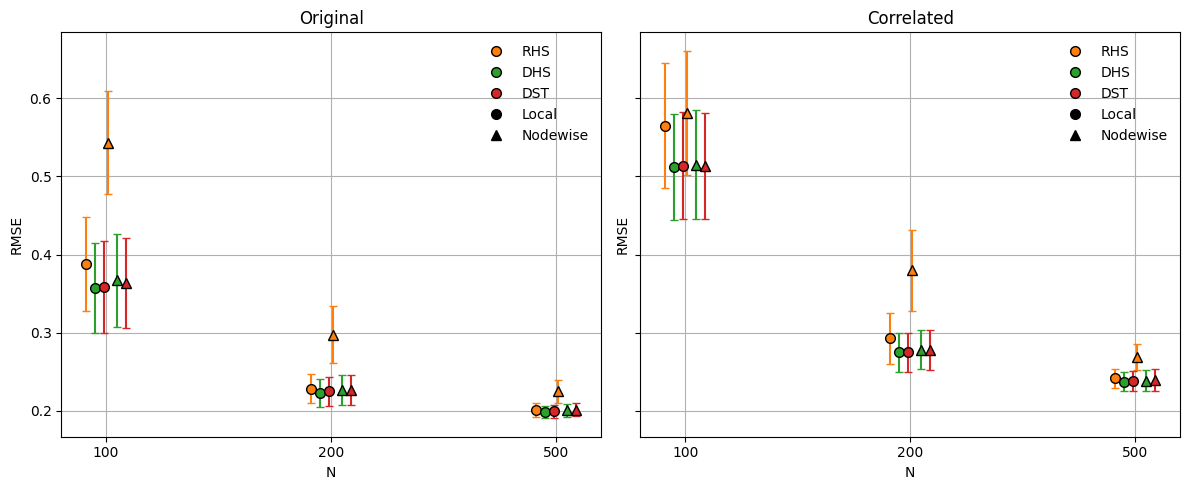

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- prepare data ---
df = df_all.copy()

abbr = {
    "Regularized Horseshoe": "RHS",
    "Dirichlet Horseshoe": "DHS",
    "Dirichlet Student T": "DST",
}

# unify model names across activations (strip " tanh")
df["model_clean"] = df["model"].str.replace(" tanh", "", regex=False)
df["model_clean"] = df["model_clean"].str.replace(" nodewise", "", regex=False)
# summary stats per (setting, N, model, activation)
summary = (
    df.groupby(["setting", "N", "model_clean", "activation"], as_index=False)["rmse"]
      .agg(mean="mean", std="std")
)

# plotting order
settings = ["Original", "Correlated"]
Ns = [100, 200, 500]
models = ["Regularized Horseshoe", "Dirichlet Horseshoe", "Dirichlet Student T"]

# visuals
markers = {"local": "o", "nodewise": "^"}            # shapes
offsets = {"local": -0.05, "nodewise": +0.05}        # side-by-side jitter on x
model_offsets = {
    "Regularized Horseshoe": -0.04,
    "Dirichlet Horseshoe": +0.00,
    "Dirichlet Student T": +0.04,
}
palette_list = plt.get_cmap("tab10").colors
palette = {m: palette_list[i+1] for i, m in enumerate(models)}

# map N to base x positions and add offsets for activation
xbase = {N: i for i, N in enumerate(Ns)}

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

for ax, setting in zip(axes, settings):
    sub = summary[summary["setting"] == setting]
    # plot each model+activation with errorbars, without lines
    for m in models:
        for act in ["local", "nodewise"]:
            g = sub[(sub["model_clean"] == m) & (sub["activation"] == act)]
            if g.empty:
                continue
            #xs = [xbase[n] + offsets[act] for n in g["N"]]
            xs = [xbase[n] + offsets[act] + model_offsets[m] for n in g["N"]]

            ax.errorbar(
                xs, g["mean"], yerr=g["std"],
                fmt=markers[act], markersize=7,
                linestyle="none", capsize=3,
                color=palette[m], markeredgecolor="black"
            )

    ax.set_title(f"{setting}")
    ax.set_xticks(range(len(Ns)))
    ax.set_xticklabels(Ns)
    ax.set_xlabel("N")
    ax.set_ylabel("RMSE")
    ax.grid()

# --- legends ---
model_handles = [
    Line2D(
        [0], [0],
        marker="o",
        linestyle="none",
        color=palette[m],
        markeredgecolor="black",
        markersize=7,
        label=abbr.get(m, m)   # <- use abbreviation
    )
    for m in models
]

# activation legend (shapes)
activation_handles = [
    Line2D([0], [0], marker=markers["local"], linestyle="none", color="black",
           markersize=7, label="Local"),
    Line2D([0], [0], marker=markers["nodewise"], linestyle="none", color="black",
           markersize=7, label="Nodewise"),
]

for ax in axes:
    ax.legend(
        handles=model_handles + activation_handles,
        title=None,
        loc="upper right",
        frameon=False,
        ncol=1
    )
plt.tight_layout(rect=(0, 0, 1, 1))
#plt.grid()
plt.show()

## SPARSITY

In [10]:
from utils.sparsity import forward_pass_relu, forward_pass_tanh, local_prune_weights

def compute_sparse_rmse_results(seeds, models, all_fits, get_N_sigma, forward_pass, folder,
                         sparsity=0.0, prune_fn=None):
    results = []
    posterior_means = []

    for seed in seeds:
        N, sigma = get_N_sigma(seed)
        dataset_key = f'Friedman_N{N}_p10_sigma{sigma:.2f}_seed{seed}'
        path = f"datasets/{folder}/{dataset_key}.npz"

        try:
            data = np.load(path)
            X_test, y_test = data["X_test"], data["y_test"]
        except FileNotFoundError:
            print(f"[SKIP] File not found: {path}")
            continue

        for model in models:
            try:
                fit = all_fits[dataset_key][model]['posterior']
                W1_samples = fit.stan_variable("W_1")           # (S, P, H)
                W2_samples = fit.stan_variable("W_L")           # (S, H, O)
                b1_samples = fit.stan_variable("hidden_bias")   # (S, O, H)
                b2_samples = fit.stan_variable("output_bias")   # (S, O)
            except KeyError:
                print(f"[SKIP] Model or posterior not found: {dataset_key} -> {model}")
                continue

            S = W1_samples.shape[0]
            rmses = np.zeros(S)
            #print(y_test.shape)
            y_hats = np.zeros((S, y_test.shape[0]))

            for i in range(S):
                W1 = W1_samples[i]
                W2 = W2_samples[i]

                # Apply pruning mask if requested
                if prune_fn is not None and sparsity > 0.0:
                    masks = prune_fn([W1, W2], sparsity)
                    W1 = W1 * masks[0]
                    #W2 = W2 * masks[1]

                y_hat = forward_pass(X_test, W1, b1_samples[i][0], W2, b2_samples[i])
                y_hats[i] = y_hat.squeeze()  # Store the prediction for each sample
                rmses[i] = np.sqrt(np.mean((y_hat.squeeze() - y_test)**2))
                
            posterior_mean = np.mean(y_hats, axis=0)
            posterior_mean_rmse = np.sqrt(np.mean((posterior_mean - y_test.squeeze())**2))

            posterior_means.append({
                'seed': seed,
                'N': N,
                'sigma': sigma,
                'model': model,
                'sparsity': sparsity,
                'posterior_mean_rmse': posterior_mean_rmse
            })

            for i in range(S):
                results.append({
                    'seed': seed,
                    'N': N,
                    'sigma': sigma,
                    'model': model,
                    'sparsity': sparsity,
                    'rmse': rmses[i]
                })

    df_rmse = pd.DataFrame(results)
    df_posterior_rmse = pd.DataFrame(posterior_means)

    return df_rmse, df_posterior_rmse


sparsity_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]

seeds = [1, 2, 11]
seeds_correlated = [1, 6, 11]

def get_N_sigma(seed):
    if seed == 1:
        N=100
    elif seed == 2:
        N=200
    else:
        N=500
    sigma=1.00
    return N, sigma

def get_N_sigma_correlated(seed):
    if seed == 1:
        N=100
    elif seed == 6:
        N=200
    else:
        N=500
    sigma=1.00
    return N, sigma

In [11]:
df_rmse_local_lambda_sparse, df_posterior_rmse_local_lambda_sparse = {}, {}
df_rmse_local_lambda_sparse_correlated, df_posterior_rmse_local_lambda_sparse_correlated = {}, {}
df_rmse_nodewise_lambda_sparse, df_posterior_rmse__nodewise_lambda_sparse = {}, {}
df_rmse_nodewise_lambda_sparse_correlated, df_posterior_rmse_nodewise_lambda_sparse_correlated = {}, {}

for sparsity in sparsity_levels:
    df_rmse_local_lambda_sparse[sparsity], df_posterior_rmse_local_lambda_sparse[sparsity] = compute_sparse_rmse_results(
        seeds, model_names_local_lambda, local_lambda_fits, get_N_sigma, forward_pass_tanh, folder = "friedman",
        sparsity=sparsity, prune_fn=local_prune_weights
    )
    
    df_rmse_local_lambda_sparse_correlated[sparsity], df_posterior_rmse_local_lambda_sparse_correlated[sparsity] = compute_sparse_rmse_results(
        seeds_correlated, model_names_local_lambda_correlated, local_lambda_fits_correlated, get_N_sigma_correlated, forward_pass_tanh, folder = "friedman_correlated",
        sparsity=sparsity, prune_fn=local_prune_weights
    )
    
    df_rmse_nodewise_lambda_sparse[sparsity], df_posterior_rmse__nodewise_lambda_sparse[sparsity] = compute_sparse_rmse_results(
        seeds, model_names_nodewise_lambda, nodewise_lambda_fits, get_N_sigma, forward_pass_tanh, folder = "friedman",
        sparsity=sparsity, prune_fn=local_prune_weights
    )
    
    df_rmse_nodewise_lambda_sparse_correlated[sparsity], df_posterior_rmse_nodewise_lambda_sparse_correlated[sparsity] = compute_sparse_rmse_results(
        seeds_correlated, model_names_nodewise_lambda_correlated, nodewise_lambda_fits_correlated, get_N_sigma_correlated, forward_pass_tanh, folder = "friedman_correlated",
        sparsity=sparsity, prune_fn=local_prune_weights
    )

In [12]:
import pandas as pd

df_rmse_full_local = pd.concat(
    [df.assign(sparsity=sparsity) for sparsity, df in df_rmse_local_lambda_sparse.items()],
    ignore_index=True
)

df_rmse_full_local_correlated = pd.concat(
    [df.assign(sparsity=sparsity) for sparsity, df in df_rmse_local_lambda_sparse_correlated.items()],
    ignore_index=True
)


df_rmse_full_nodewise = pd.concat(
    [df.assign(sparsity=sparsity) for sparsity, df in df_rmse_nodewise_lambda_sparse.items()],
    ignore_index=True
)

df_rmse_full_nodewise_correlated = pd.concat(
    [df.assign(sparsity=sparsity) for sparsity, df in df_rmse_nodewise_lambda_sparse_correlated.items()],
    ignore_index=True
)


df_local_o = df_rmse_full_local.copy()
df_local_o["model"] = df_local_o["model"].str.replace(" tanh", "", regex=False)

df_local_c = df_rmse_full_local_correlated.copy()
df_local_c["model"] = df_local_c["model"].str.replace(" tanh", "", regex=False)

df_nodewise_o = df_rmse_full_nodewise.copy()
df_nodewise_o["model"] = df_nodewise_o["model"].str.replace(" tanh nodewise", "", regex=False)

df_nodewise_c = df_rmse_full_nodewise_correlated.copy()
df_nodewise_c["model"] = df_nodewise_c["model"].str.replace(" tanh nodewise", "", regex=False)


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import pandas as pd
from collections import OrderedDict

# --- Your palettes and abbreviations ---
palette = {
    "Regularized Horseshoe": "C1",
    "Dirichlet Horseshoe": "C2",
    "Dirichlet Student T": "C3",
}
abbr = {
    "Regularized Horseshoe": "RHS",
    "Dirichlet Horseshoe": "DHS",
    "Dirichlet Student T": "DST",
}

def make_merged_df(
    df_local_o, df_local_c, df_nodewise_o, df_nodewise_c,
    drop_tanh_suffix=True
):
    """Return one long df with columns: N, sparsity, rmse, model, activation, setting."""
    dfs = []
    # Tanh (optionally strip ' tanh' from model names if present)
    for df, setting in [(df_local_o, "Original"), (df_local_c, "Correlated")]:
        d = df.copy()
        if drop_tanh_suffix and " tanh" in "".join(d["model"].unique()):
            d["model"] = d["model"].str.replace(" tanh", "", regex=False)
        d["activation"] = "Local"
        d["setting"] = setting
        dfs.append(d)
    # ReLU
    for df, setting in [(df_nodewise_o, "Original"), (df_nodewise_c, "Correlated")]:
        d = df.copy()
        if drop_tanh_suffix and " tanh nodewise" in "".join(d["model"].unique()):
            d["model"] = d["model"].str.replace(" tanh nodewise", "", regex=False)
        d["activation"] = "Nodewise"
        d["setting"] = setting
        dfs.append(d)
    out = pd.concat(dfs, ignore_index=True)

    # Keep only models that exist in BOTH activations so legend doesn't show ghosts
    models_local = set(out.loc[out.activation=="Local","model"].unique())
    models_nodewise = set(out.loc[out.activation=="Nodewise","model"].unique())
    common_models = sorted(list(models_local & models_nodewise))
    if common_models:
        out = out[out["model"].isin(common_models)]
    return out

df_all = make_merged_df(df_local_o, df_local_c, df_nodewise_o, df_nodewise_c)


In [14]:
def plot_rmse_one_figure(
    df_all,
    Ns=(100, 200, 500), figsize=(12, 7), title="Original vs Correlated"
):
    

    # Orderings
    setting_order = ["Original", "Correlated"]
    activation_order = ["Local", "Nodewise"]

    # Seaborn aesthetics (keeps your 'talk' sizing / whitegrid)
    #sns.set_context("talk")
    sns.set_style("whitegrid")
    plt.rcParams.update({
        "axes.spines.top": False,
        "axes.spines.right": False,
        #"axes.titleweight": "semibold",
        "legend.frameon": True
    })

    fig, axes = plt.subplots(2, len(Ns), figsize=figsize, sharex=True, sharey="col")
    if len(Ns) == 1:
        axes = axes.reshape(2, 1)

    # We’ll plot using seaborn’s style mapping (style=activation, markers=True, dashes=True)
    # so tanh vs ReLU are visually distinct and consistent across the grid.
    for j, Nval in enumerate(Ns):
        for i, setting in enumerate(setting_order):
            ax = axes[i, j]
            dfN = df_all[(df_all["N"] == Nval) & (df_all["setting"] == setting)].copy()
            # Safety: if empty, skip
            if dfN.empty:
                ax.set_visible(False)
                continue

            # Use abbreviated labels on the legend (we’ll build custom legends later anyway)
            dfN["model_abbr"] = dfN["model"].map(lambda m: abbr.get(m, m))

            sns.lineplot(
                data=dfN,
                x="sparsity",
                y="rmse",
                hue="model_abbr",      # color = prior (abbr)
                style="activation",    # style = activation
                markers=True,
                dashes=True,
                palette={abbr[k]: v for k, v in palette.items() if k in dfN["model"].unique()},
                hue_order=[abbr[m] for m in sorted(dfN["model"].unique(), key=lambda x: list(palette).index(x) if x in palette else 999)],
                style_order=activation_order,
                errorbar=None,
                ax=ax,
            )
            #ax.set_title(f"N={Nval}")
            ax.set_title(f"N={Nval}", fontweight="normal")

            ax.set_xlabel("Sparsity")
            ax.set_ylabel("RMSE" if j == 0 else "")
            ax.grid(True, which="major", alpha=0.25)
            if ax.legend_:  # remove local legends
                ax.legend_.remove()

    # ---------- Build two clean, global legends ----------
    # 1) Prior legend (colors), using abbreviations in desired order present in data
    models_present = []
    for m in ["Regularized Horseshoe", "Dirichlet Horseshoe", "Dirichlet Student T"]:
        if (df_all["model"] == m).any():
            models_present.append(m)
    prior_handles = [
        Line2D([0],[0], color=palette[m], marker='o', linestyle='-', linewidth=2, markersize=7)
        for m in models_present
    ]
    prior_labels = [abbr[m] for m in models_present]

    # 2) Activation legend (styles) – black lines with linestyle/markers
    # Let seaborn pick the default mapping; we emulate a solid for tanh and dashed for ReLU.
    act_style = {
        "Local": dict(linestyle='-'),#, marker='o'),
        "Nodewise": dict(linestyle='--'),#, marker='s'),
    }
    activation_handles = [
        Line2D([0],[0], color='black', linewidth=2, markersize=7, **act_style[act])
        for act in activation_order
        if (df_all["activation"] == act).any()
    ]
    activation_labels = [act for act in activation_order if (df_all["activation"] == act).any()]

    # Place legends: priors on top center, activations below it
    # (Adjust bbox_to_anchor if you prefer side-by-side or bottom placement.)
    if prior_handles:
        leg1 = fig.legend(
            prior_handles, prior_labels,
            title="Prior",
            loc="upper right",
            ncol=len(prior_handles),
            frameon=True,
            bbox_to_anchor=(0.6, 1.02)
        )
        fig.add_artist(leg1)
    if activation_handles:
        fig.legend(
            activation_handles, activation_labels,
            title="Activation",
            loc="upper left",
            ncol=len(activation_handles),
            frameon=True,
            bbox_to_anchor=(0.6, 1.02)
        )
    #fig.suptitle(title, y=1.08, fontsize=18)
    #plt.tight_layout(rect=[0.02, 0.02, 0.98, 0.94])
    plt.show()


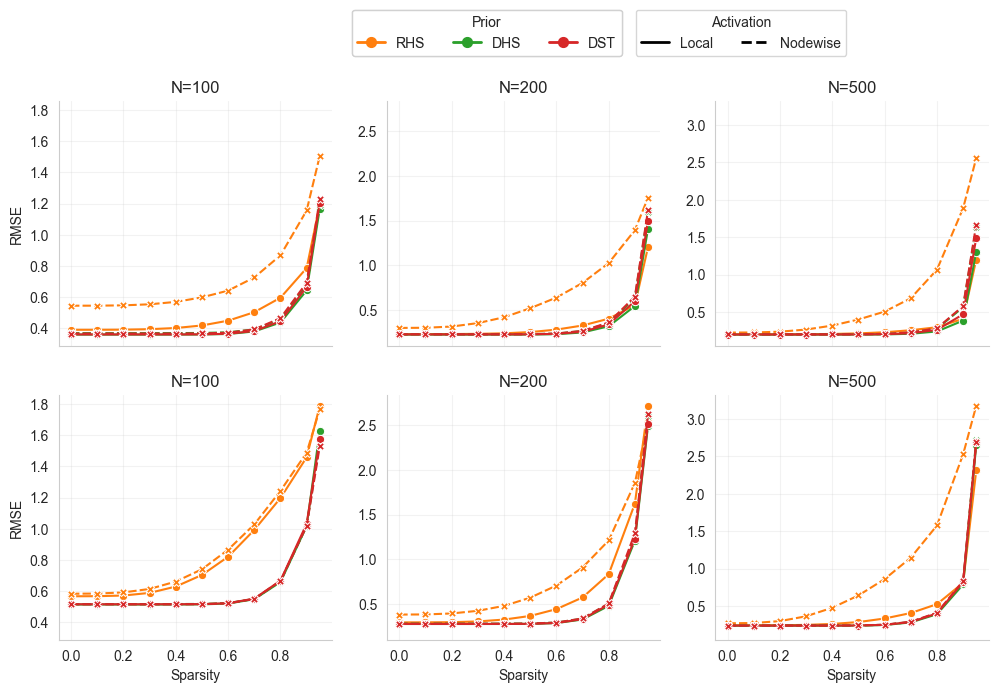

In [25]:

plot_rmse_one_figure(df_all,
                     Ns=(100, 200, 500),
                     title="Original vs Correlated")


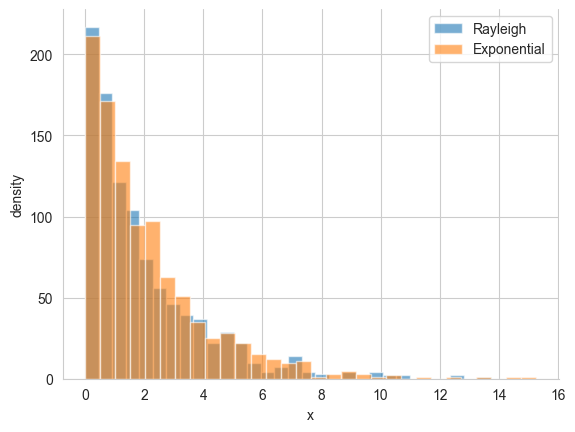

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import rayleigh, expon, dirichlet

# --- scale parameter ---
s = 1.0

# --- distributions ---
#x = np.linspace(0, 10, 1000)

# version A: Rayleigh with scale s
#pdf_A = rayleigh(scale=s).pdf(x)
#pdf_C = expon(scale=1/2).pdf(x)

# version B: Rayleigh(1) scaled outside: lambda = s * R
# => density of s * R is 1/s * Rayleigh(1)(x/s)
#pdf_B = (1/s) * rayleigh(scale=1).pdf(x / s)

samples_A = rayleigh.rvs(size=1000, scale=1)
samples_B = expon.rvs(size=1000, scale=2)

plt.hist(samples_A**2, bins=30, alpha=0.6, label="Rayleigh")
plt.hist(samples_B, bins=30, alpha=0.6, label="Exponential")
plt.legend()
plt.xlabel("x")
plt.ylabel("density")
plt.show()


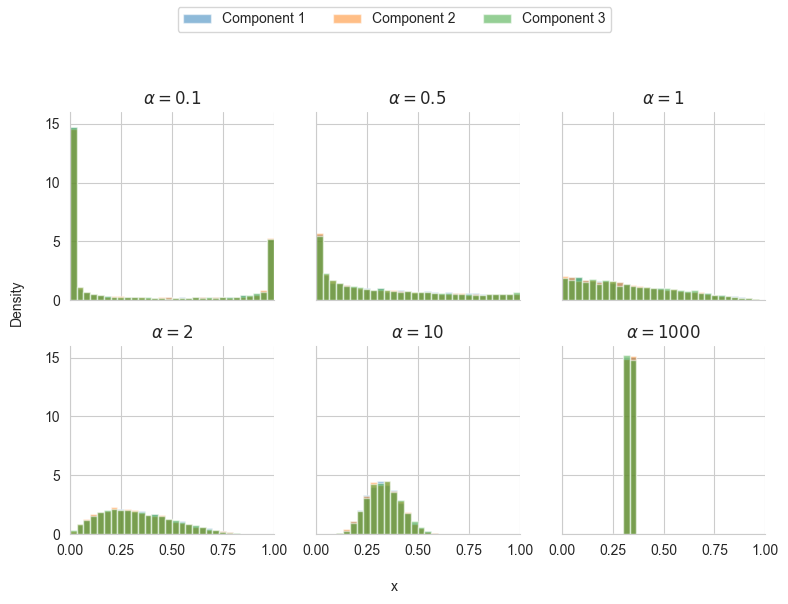

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet

# --- settings ---
alphas = [0.1, 0.5, 1, 2, 10, 1000]
n_samples = 5000
K = 3  # dimension of the Dirichlet
bins = np.linspace(0, 1, 31)  # common bins for all histograms

fig, axes = plt.subplots(2, 3, figsize=(8, 6), sharex=True, sharey=True)
axes = axes.ravel()

colors = ["C0", "C1", "C2"]
labels = ["Component 1", "Component 2", "Component 3"]

for ax, a in zip(axes, alphas):
    # symmetric Dirichlet(alpha, alpha, alpha)
    alpha_vec = np.full(K, a)
    samples = dirichlet.rvs(alpha_vec, size=n_samples)

    # plot all three components in the same subplot
    for k in range(K):
        ax.hist(
            samples[:, k],
            bins=bins,
            density=True,
            alpha=0.5,
            color=colors[k],
            label=labels[k] if a == alphas[0] else None,  # avoid repeated legend entries
        )

    ax.set_title(rf"$\alpha = {a}$")
    ax.set_xlim(0, 1)

# common labels
fig.text(0.5, 0.02, "x", ha="center")
fig.text(0.02, 0.5, "Density", va="center", rotation="vertical")

# one shared legend
handles, leg_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, leg_labels, loc="upper center", ncol=3)

plt.tight_layout(rect=[0.03, 0.05, 1, 0.88])
plt.show()
